In [313]:
import pandas as pd

x_train = pd.read_csv('Dataset/x_train_all.csv')
y_train = pd.read_csv('Dataset/y_train_all.csv')

merged_df = pd.concat([x_train, y_train], axis=1)



In [314]:
data = x_train.iloc[1:9690]

x_train.iloc[:1]

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0


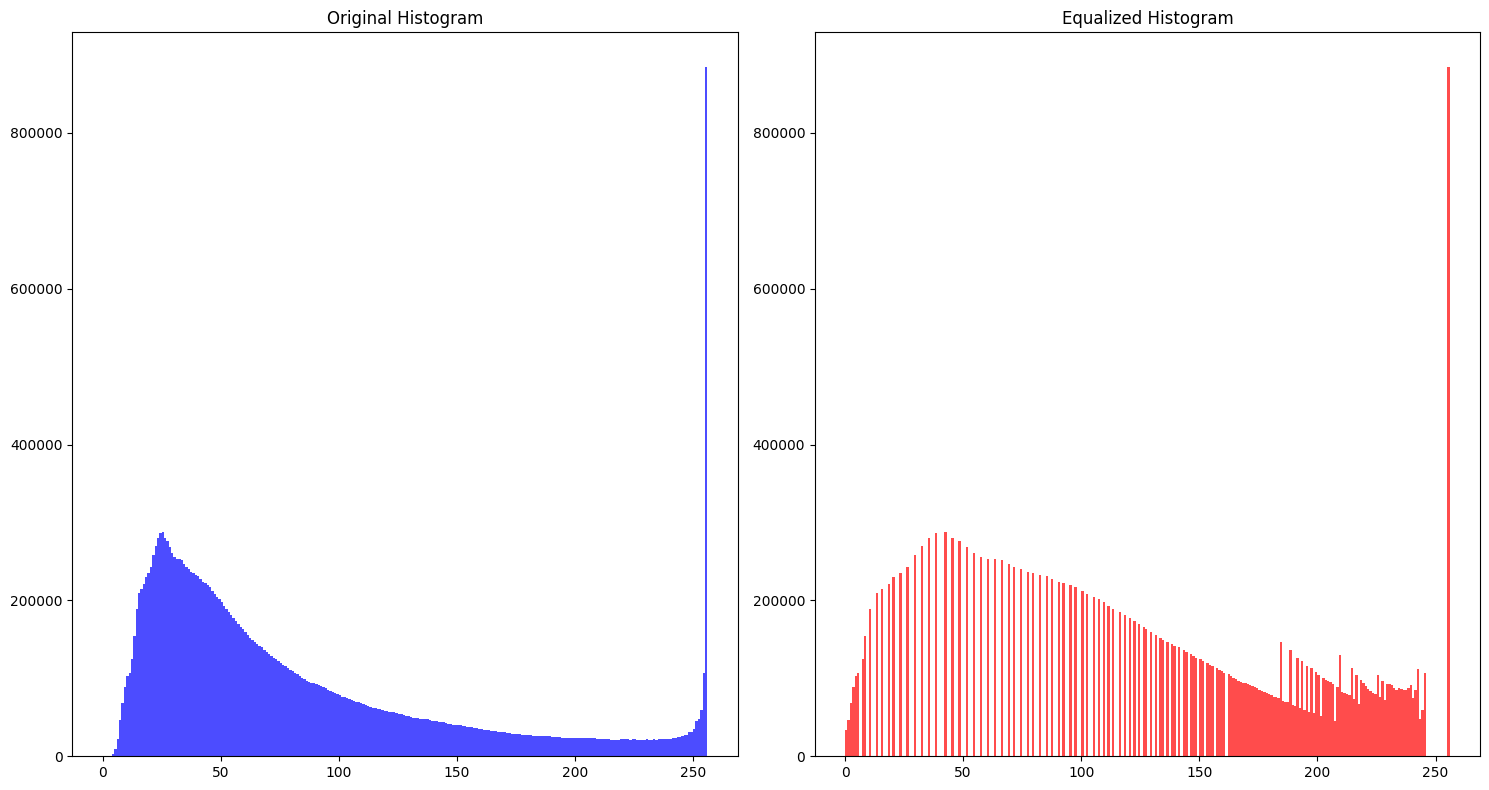

In [315]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_data = np.array(data, dtype=np.uint8)

equalized_image = cv2.equalizeHist(image_data)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(equalized_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Equalized Histogram')

plt.tight_layout()
plt.show()

In [316]:
#Contrast Limited Adaptive Histogram Equalization 
def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

def brighten(row, target_mean_brightness=128, max_brightness_adjustment=50):
    current_mean_brightness = np.mean(row)
    brightness_adjustment = target_mean_brightness - current_mean_brightness
    brightness_adjustment = np.clip(brightness_adjustment, -max_brightness_adjustment, max_brightness_adjustment)
    scaling_factor = (current_mean_brightness + brightness_adjustment) / current_mean_brightness
    adjusted_row = row * scaling_factor
    adjusted_row[adjusted_row < 0] = 0
    adjusted_row[adjusted_row > 255] = 255
    return adjusted_row


def apply_gamma_correction(row, gamma=1.8):
    input_shape = row.shape
    row = np.array(row, dtype=np.uint8)
    corrected_row = ((row / 255.0) ** (1 / gamma) * 255).astype(np.uint8)
    corrected_row = corrected_row.reshape(*input_shape) 
    return corrected_row

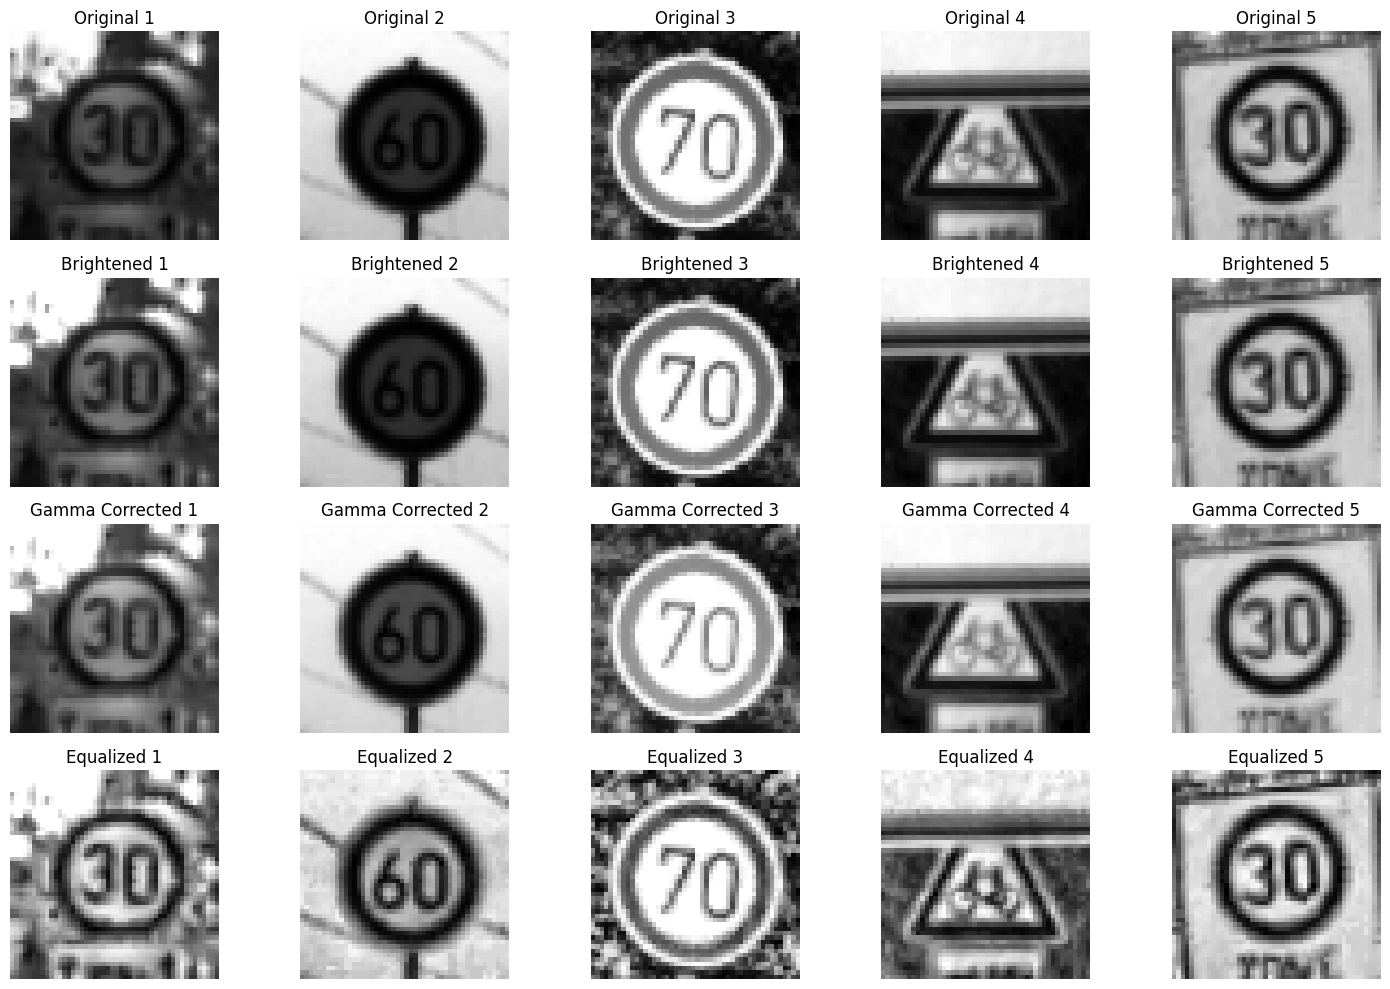

In [317]:

x_copy = x_train.copy()

sample_size = 5
sample_indices = x_copy.sample(sample_size).index


plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    plt.subplot(4, sample_size, i + 1)
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    brightened_image = brighten(x_copy.iloc[idx].values)
    plt.subplot(4, sample_size, sample_size + i + 1)
    brightened_image = brightened_image.reshape(48, 48)
    plt.imshow(brightened_image, cmap='gray')
    plt.title(f'Brightened {i+1}')
    plt.axis('off')

    gamma_image = apply_gamma_correction(brightened_image)
    plt.subplot(4, sample_size, 2*sample_size + i + 1)
    plt.imshow(gamma_image, cmap='gray')
    plt.title(f'Gamma Corrected {i+1}')
    plt.axis('off')

    equalized_image = apply_clahe(gamma_image)
    plt.subplot(4, sample_size, 3*sample_size + i + 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Equalized {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [318]:
processed_images = []

sample_size = 5
sample_indices = x_copy.sample(sample_size).index

for i, idx in enumerate(sample_indices):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)

    processed_images.append(equalized_image.flatten())

processed_df_subset = pd.DataFrame(processed_images)
processed_df_subset.shape

(5, 2304)

In [319]:
processed_images = []

for i, idx in enumerate(x_copy.index):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)
    processed_images.append(equalized_image.flatten())

processed_df = pd.DataFrame(processed_images)
processed_df.shape

(9690, 2304)

In [320]:
x_train.shape

(9690, 2304)

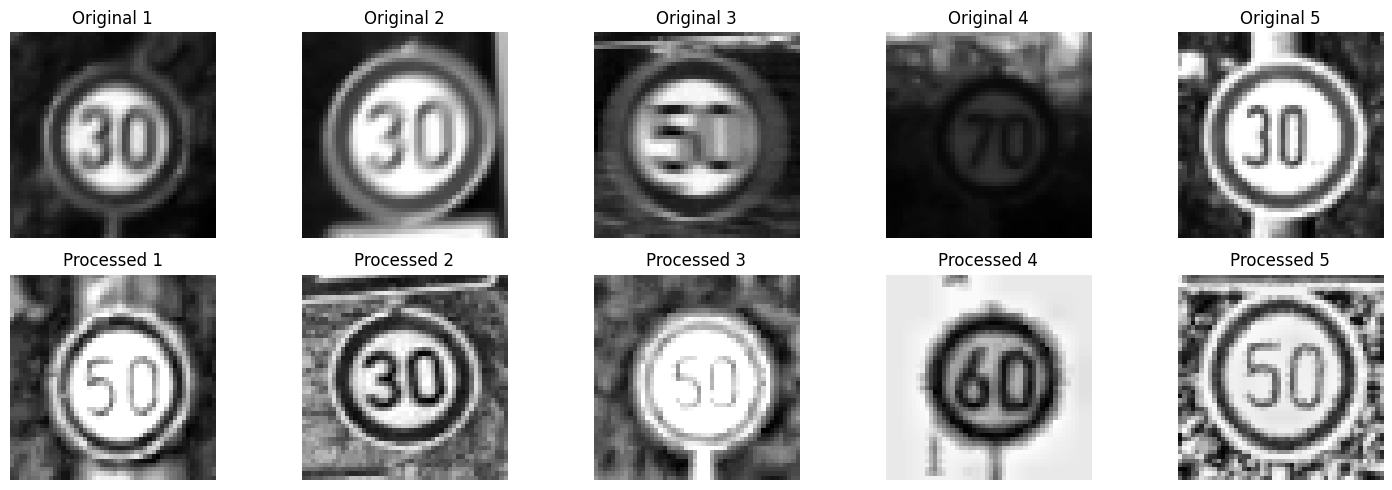

In [321]:

x_train_reset = x_copy.reset_index(drop=True)
sample_size = 5
sample_indices = x_copy.sample(sample_size).index
plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    original_image = x_train_reset.iloc[idx].values.reshape(48, 48)
    processed_image = processed_df_subset.iloc[i].values.reshape(48, 48)

    plt.subplot(2, sample_size, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(2, sample_size, sample_size + i + 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f'Processed {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [322]:
merged_df.shape

(9690, 2305)

In [323]:
# merged_df.to_csv("merged_df.csv")

In [324]:
# processed_df.to_csv("processed_df.csv")

In [325]:
processed_df.shape

(9690, 2304)

In [326]:
y_train.shape

(9690, 1)

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, multilabel_confusion_matrix
from sklearn.metrics._classification import _nanaverage

seed_value = 22

X_train, X_test, Y_train, Y_test = train_test_split(processed_df, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)
predicted_probs = gnb.predict_proba(X_test)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [328]:
accuracy = accuracy_score(Y_test, predicted)
f1 = f1_score(Y_test, predicted, average="weighted")
precision = precision_score(Y_test, predicted, average="weighted")
recall = recall_score(Y_test, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test, predicted)
roc = roc_auc_score(Y_test, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.49810801513587893
F1 Score: 0.5076464069040112
Precision: 0.5799946290969333
Recall/Sensitivity/True Positive Rate: 0.49810801513587893
Specificity: 0.920423278954211
False Positive Rate: 0.07957672104578879
Area under ROC curve: 0.8316810687426335
Confusion Matrix:
 [[ 49   4   5   0   4   0   2   0   0   1]
 [159 211  84  62 132   0  17   0   0  21]
 [ 23  72 315  66 136   2  39   0   0  11]
 [ 20  15  32 183 109   0  42   0   0  19]
 [ 43  27  36  64 389   0  18   0   0   6]
 [  0   0   0   0   2  47  10   1   2   3]
 [  0   1   0   1   1   7  71   0   3  20]
 [  0   0   0   0   0   5   2  43   1  14]
 [  0   1   1   2   0  22  26   3  99  24]
 [  0   0   1   1   3  15  11   0   5  41]]


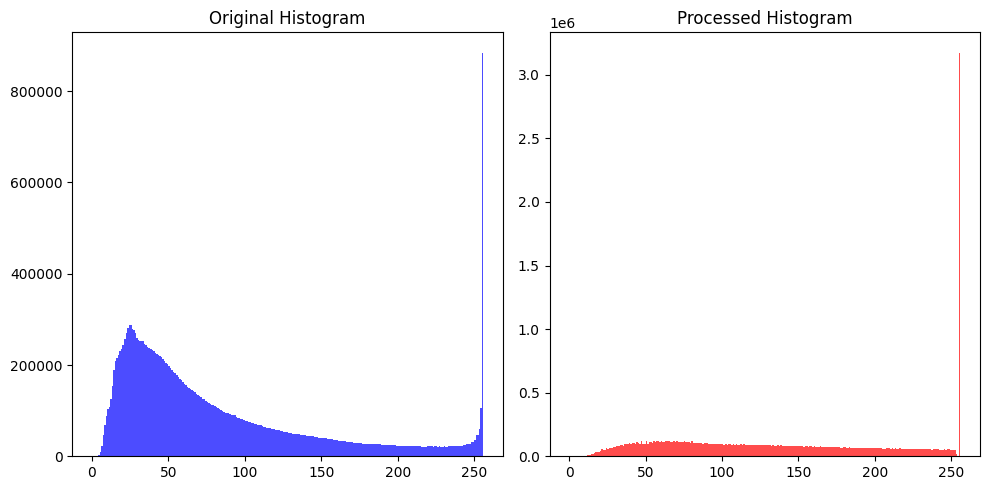

In [329]:
image_data = np.array(data, dtype=np.uint8)

processed_image = apply_clahe(apply_gamma_correction(brighten(image_data)))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [330]:
# Z normalization to preprocessed data
mean=processed_df.mean()
std=processed_df.std()
processed_df_norm=(processed_df-mean)/std

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(processed_df_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_norm, Y_train_norm)

predicted = gnb.predict(X_test_norm)
predicted_probs = gnb.predict_proba(X_test_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [332]:
accuracy = accuracy_score(Y_test_norm, predicted)
f1 = f1_score(Y_test_norm, predicted, average="weighted")
precision = precision_score(Y_test_norm, predicted, average="weighted")
recall = recall_score(Y_test_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_norm, predicted)
roc = roc_auc_score(Y_test_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.49810801513587893
F1 Score: 0.5076464069040112
Precision: 0.5799946290969333
Recall/Sensitivity/True Positive Rate: 0.49810801513587893
Specificity: 0.920423278954211
False Positive Rate: 0.07957672104578879
Area under ROC curve: 0.831769949759648
Confusion Matrix:
 [[ 49   4   5   0   4   0   2   0   0   1]
 [159 211  84  62 132   0  17   0   0  21]
 [ 23  72 315  66 136   2  39   0   0  11]
 [ 20  15  32 183 109   0  42   0   0  19]
 [ 43  27  36  64 389   0  18   0   0   6]
 [  0   0   0   0   2  47  10   1   2   3]
 [  0   1   0   1   1   7  71   0   3  20]
 [  0   0   0   0   0   5   2  43   1  14]
 [  0   1   1   2   0  22  26   3  99  24]
 [  0   0   1   1   3  15  11   0   5  41]]


In [333]:
# Outlier mining to processed data

from sklearn.ensemble import IsolationForest

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(processed_df)

outlier_indices = processed_df.index[outliers == -1]

x_train_no_outliers = processed_df.drop(outlier_indices)
y_train_no_outliers = y_train.loc[x_train_no_outliers.index]

print(x_train_no_outliers.shape)
y_train_no_outliers.shape

(9593, 2304)


(9593, 1)

In [334]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train_out, X_test_out, Y_train_out, Y_test_out = train_test_split(x_train_no_outliers, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_out, Y_train_out)

predicted = gnb.predict(X_test_out)
predicted_probs = gnb.predict_proba(X_test_out)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [335]:
accuracy = accuracy_score(Y_test_out, predicted)
f1 = f1_score(Y_test_out, predicted, average="weighted")
precision = precision_score(Y_test_out, predicted, average="weighted")
recall = recall_score(Y_test_out, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_out, predicted)
roc = roc_auc_score(Y_test_out, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_out, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5013898540653231
F1 Score: 0.5119362463333927
Precision: 0.5780388765465759
Recall/Sensitivity/True Positive Rate: 0.5013898540653231
Specificity: 0.9207742536414885
False Positive Rate: 0.07922574635851155
Area under ROC curve: 0.8319065309993822
Confusion Matrix:
 [[ 38  11   4   2   6   0   1   0   0   0]
 [157 219  89  53 115   0  16   0   0   8]
 [ 30  57 295  79 140   4  53   0   0  11]
 [ 24  11  38 165  86   0  77   0   1   6]
 [ 36  23  57  56 387   1  21   0   0   3]
 [  0   0   0   0   0  54   7   3   4   1]
 [  0   1   0   2   2  10  74   0   4  24]
 [  0   0   0   0   0   4   5  49   2   9]
 [  1   0   0   1   1  23  24   4 103   6]
 [  1   2   0   0   2   7   7   0   2  59]]


In [336]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [337]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)
predicted_probs = gnb.predict_proba(X_test)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [338]:
accuracy = accuracy_score(Y_test, predicted)
f1 = f1_score(Y_test, predicted, average="weighted")
precision = precision_score(Y_test, predicted, average="weighted")
recall = recall_score(Y_test, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test, predicted)
roc = roc_auc_score(Y_test, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5013898540653231
F1 Score: 0.5119362463333927
Precision: 0.5780388765465759
Recall/Sensitivity/True Positive Rate: 0.5013898540653231
Specificity: 0.9207742536414885
False Positive Rate: 0.07922574635851155
Area under ROC curve: 0.8321057943057177
Confusion Matrix:
 [[ 38  11   4   2   6   0   1   0   0   0]
 [157 219  89  53 115   0  16   0   0   8]
 [ 30  57 295  79 140   4  53   0   0  11]
 [ 24  11  38 165  86   0  77   0   1   6]
 [ 36  23  57  56 387   1  21   0   0   3]
 [  0   0   0   0   0  54   7   3   4   1]
 [  0   1   0   2   2  10  74   0   4  24]
 [  0   0   0   0   0   4   5  49   2   9]
 [  1   0   0   1   1  23  24   4 103   6]
 [  1   2   0   0   2   7   7   0   2  59]]


In [339]:
no_out_processed_df_norm.shape

(9593, 2304)

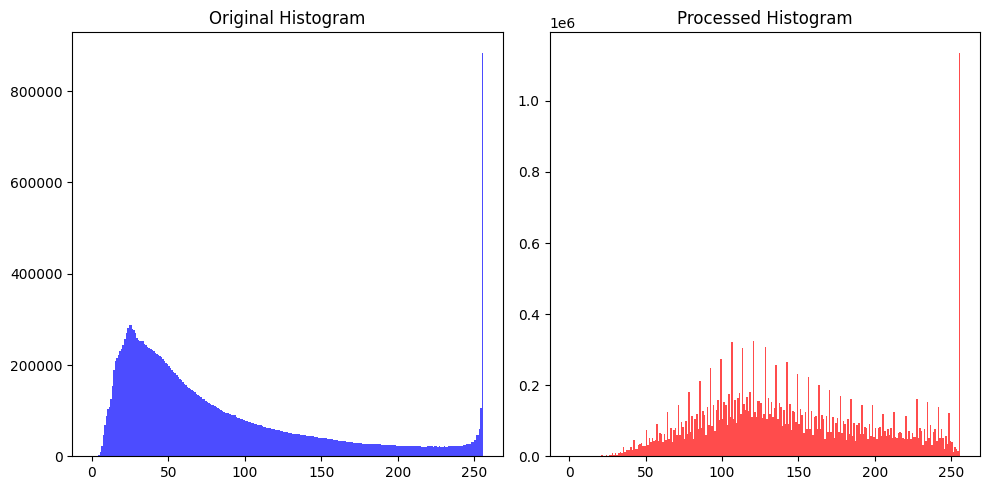

In [340]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [341]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 26

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)
predicted_probs = gnb.predict_proba(X_test)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [343]:
accuracy = accuracy_score(Y_test, predicted)
f1 = f1_score(Y_test, predicted, average="weighted")
precision = precision_score(Y_test, predicted, average="weighted")
recall = recall_score(Y_test, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test, predicted)
roc = roc_auc_score(Y_test, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.47498262682418346
F1 Score: 0.4839422133537431
Precision: 0.5410069486766262
Recall/Sensitivity/True Positive Rate: 0.47498262682418346
Specificity: 0.908487569550592
False Positive Rate: 0.09151243044940793
Area under ROC curve: 0.8153026066181263
Confusion Matrix:
 [[ 27  18   2   2   9   0   2   0   0   0]
 [144 187  88  58 134   0  11   0   0  12]
 [ 34  61 293  84 146   2  52   0   0   8]
 [ 39  13  31 156 118   0  46   0   0   8]
 [ 37  47  55  71 404   0  14   0   0   2]
 [  0   0   0   0   4  52   9   1   1   5]
 [  0   0   1   2   2  16  73   0   4  14]
 [  0   0   0   0   0   5   4  44   3  10]
 [  0   0   1   0   1  21  27   4  85   5]
 [  0   2   0   0   1  11   6   0   3  46]]


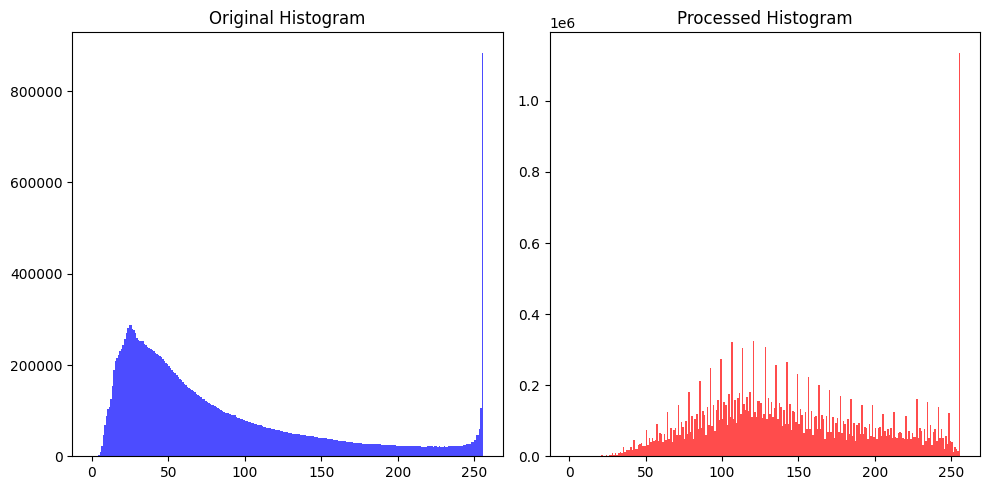

In [344]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [345]:
y_train=y_train.rename(columns={'0':'label'})

In [346]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [347]:
merged_df = pd.concat([x_train, y_train], axis=1)



In [348]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,label
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0,0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0,0
2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0,0
3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0,0
4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,247.0,220.0,254.0,213.0,129.0,208.0,254.0,255.0,255.0,255.0,...,29.0,27.0,26.0,25.0,23.0,22.0,26.0,26.0,27.0,9
9686,151.0,118.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,252.0,...,31.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,27.0,9
9687,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,49.0,42.0,36.0,33.0,36.0,39.0,31.0,39.0,43.0,9
9688,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,27.0,26.0,27.0,35.0,28.0,27.0,26.0,26.0,24.0,9


In [349]:
from sklearn.decomposition import PCA

df = merged_df
target_column = 'label'
features = df.drop(target_column, axis=1)
target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(features)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca)

Transformed DataFrame:
              PC1          PC2          PC3          PC4         PC5  \
0     1833.678654  -327.432280  -247.743190  -608.483725 -348.793585   
1     1859.007019  -349.977157  -192.222284  -595.379147 -443.962324   
2     1764.509881  -388.614024  -133.034248  -686.073427 -473.539395   
3     1676.632914  -400.702911  -100.745308  -732.746033 -495.178381   
4     1902.532764  -338.990792   -62.149332  -692.201419 -284.736494   
...           ...          ...          ...          ...         ...   
9685   987.795453  1450.984446 -1503.450258 -1658.624173 -413.021042   
9686  1017.324304  1511.469231 -1452.548502 -1577.032596 -653.548401   
9687   985.864551  1719.211492 -1749.455042 -1361.267595   28.937440   
9688  1180.694571  1818.178520 -1816.040253 -1798.650931 -378.454303   
9689   564.088760  1545.222780  -854.697719 -1612.762414 -809.463741   

             PC6         PC7          PC8         PC9        PC10        PC11  \
0     651.336689  303.656139   

In [350]:
df_pca_top5 = df_pca.iloc[:, :5]
df_pca_top10 = df_pca.iloc[:, :10]
df_pca_top20 = df_pca.iloc[:, :20]


In [351]:
target

0       0
1       0
2       0
3       0
4       0
       ..
9685    9
9686    9
9687    9
9688    9
9689    9
Name: label, Length: 9690, dtype: int64

In [352]:

df_pca_top5

,PC1,PC2,PC3,PC4,PC5
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793585
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962324
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539395
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178381
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736494
...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624173,-413.021042
9686,1017.324304,1511.469231,-1452.548502,-1577.032596,-653.548401
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937440
9688,1180.694571,1818.178520,-1816.040253,-1798.650931,-378.454303


In [353]:

df_pca_top10

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793585,651.336689,303.656139,-10.808910,-408.737225,-79.937134
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962324,680.431300,207.689905,5.860541,-543.227890,-130.358703
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539395,771.513301,156.383412,138.760685,-385.597779,-246.734499
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178381,677.334757,92.548769,214.775938,-312.436535,-322.255508
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736494,617.853669,387.861270,-36.146958,-536.267855,51.231241
...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624173,-413.021042,-330.777651,181.004894,-1054.855098,903.460628,-37.748666
9686,1017.324304,1511.469231,-1452.548502,-1577.032596,-653.548401,-414.617195,-148.818329,-821.675587,789.397005,71.776356
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937440,290.977623,280.584832,-954.102477,352.119439,-86.533655
9688,1180.694571,1818.178520,-1816.040253,-1798.650931,-378.454303,-145.034628,361.182995,-795.636744,375.357662,-119.636070


In [354]:

df_pca_top20


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793585,651.336689,303.656139,-10.808910,-408.737225,-79.937134,400.216392,-535.072507,92.637290,-329.376557,-154.869069,-113.424295,158.728999,190.108848,-141.352915,-72.982393
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962324,680.431300,207.689905,5.860541,-543.227890,-130.358703,357.889833,-594.524587,123.199023,-213.297985,-83.676583,-148.488112,237.616458,178.587476,81.460337,-10.871418
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539395,771.513301,156.383412,138.760685,-385.597779,-246.734499,345.030418,-392.823945,60.507037,-147.891522,-171.778987,-89.802055,153.780967,298.290154,209.944638,-23.223279
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178381,677.334757,92.548769,214.775938,-312.436535,-322.255508,328.961862,-277.309604,61.186694,-119.370448,-247.150593,-44.919888,92.223080,280.075860,249.298869,-257.030050
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736494,617.853669,387.861270,-36.146958,-536.267855,51.231241,347.805807,-250.267355,206.638243,-249.657630,-64.522036,-206.167349,114.935947,210.495904,-13.286021,329.073135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624173,-413.021042,-330.777651,181.004894,-1054.855098,903.460628,-37.748666,-247.920366,49.262395,200.377169,-507.001023,40.537758,-146.288163,357.457048,-117.413026,-185.279594,288.282947
9686,1017.324304,1511.469231,-1452.548502,-1577.032596,-653.548401,-414.617195,-148.818329,-821.675587,789.397005,71.776356,-364.857210,-28.003392,618.341541,-114.340603,-38.765118,-202.799340,184.307777,0.942894,90.388057,83.045110
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937440,290.977623,280.584832,-954.102477,352.119439,-86.533655,68.031858,18.449721,540.926613,229.443822,-89.413278,-477.566467,246.637650,407.624245,230.135802,276.871607
9688,1180.694571,1818.178520,-1816.040253,-1798.650931,-378.454303,-145.034628,361.182995,-795.636744,375.357662,-119.636070,179.087031,-82.390709,784.815149,21.846767,-34.896105,-389.897198,413.099319,545.914664,247.808165,60.638585


In [355]:
#Unprocessed data PCA applied top 5 seed 22
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 20

X_train_5, X_test_5, Y_train_5, Y_test_5= train_test_split(df_pca_top5, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5, Y_train_5)

predicted = gnb.predict(X_test_5)
predicted_probs = gnb.predict_proba(X_test_5)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [356]:
accuracy = accuracy_score(Y_test_5, predicted)
f1 = f1_score(Y_test_5, predicted, average="weighted")
precision = precision_score(Y_test_5, predicted, average="weighted")
recall = recall_score(Y_test_5, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_5, predicted)
roc = roc_auc_score(Y_test_5, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_5, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3402132782937736
F1 Score: 0.31245444978834913
Precision: 0.33569469534022206
Recall/Sensitivity/True Positive Rate: 0.3402132782937736
Specificity: 0.8355787296278905
False Positive Rate: 0.1644212703721095
Area under ROC curve: 0.708693230933122
Confusion Matrix:
 [[  4  28  12   0   7   0   0   1   0   0]
 [  4 283 155  23 199   0   3   0  23   4]
 [  5 107 191  60 298   0   4   1   8   0]
 [  2  39  19  95 245   1   2   0   9   1]
 [  1  43  89  40 393   0   6   0   7   0]
 [  0   2  18   2  40   0   0   0   0   0]
 [  0   4   0  23  88   1   3   0   3   0]
 [  0   4  18  11  32   1   0   0   5   0]
 [  0  46  13   8  81   1   0   0  20   0]
 [  0   6   5   8  44   0   0   0   8   0]]


In [357]:
#Unprocessed data PCA applied top 10 seed 24
seed_value = 24

X_train_10, X_test_10, Y_train_10, Y_test_10= train_test_split(df_pca_top10, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10, Y_train_10)

predicted = gnb.predict(X_test_10)
predicted_probs = gnb.predict_proba(X_test_10)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [358]:
accuracy = accuracy_score(Y_test_10, predicted)
f1 = f1_score(Y_test_10, predicted, average="weighted")
precision = precision_score(Y_test_10, predicted, average="weighted")
recall = recall_score(Y_test_10, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_10, predicted)
roc = roc_auc_score(Y_test_10, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_10, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.38837289301685585
F1 Score: 0.3746075501329765
Precision: 0.4161582614101043
Recall/Sensitivity/True Positive Rate: 0.38837289301685585
Specificity: 0.8656358772188557
False Positive Rate: 0.13436412278114454
Area under ROC curve: 0.7543187792424159
Confusion Matrix:
 [[ 11  25   9   1  17   0   0   0   0   0]
 [  7 297 110  17 194   4  18   1  14   5]
 [  6 120 161  52 299   7  22  11   2   1]
 [  5  44  22  89 237   2  22   1   5   1]
 [  1  54  86  50 397   2  12   0   1   0]
 [  0   2   1   0   2  35   5   0   4   1]
 [  0   0   0   4   6  37  54   1   0  11]
 [  1  10   1   3   1  10   9  29   5   4]
 [  1  16   2   0   2  42  33  13  45  10]
 [  0  11   6   0  10  14   2   8   3  11]]


In [359]:
#Unprocessed data PCA applied top 20 seed 22
seed_value = 24

X_train_20, X_test_20, Y_train_20, Y_test_20= train_test_split(df_pca_top20, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20, Y_train_20)

predicted = gnb.predict(X_test_20)
predicted_probs = gnb.predict_proba(X_test_20)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [360]:
accuracy = accuracy_score(Y_test_20, predicted)
f1 = f1_score(Y_test_20, predicted, average="weighted")
precision = precision_score(Y_test_20, predicted, average="weighted")
recall = recall_score(Y_test_20, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_20, predicted)
roc = roc_auc_score(Y_test_20, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_20, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3522531819745442
F1 Score: 0.3570188324874217
Precision: 0.4109884617255271
Recall/Sensitivity/True Positive Rate: 0.3522531819745442
Specificity: 0.8811717241708064
False Positive Rate: 0.11882827582919381
Area under ROC curve: 0.7428409719970025
Confusion Matrix:
 [[ 10  23   6   6  17   0   1   0   0   0]
 [ 11 301 103  40 146   0  62   0   0   4]
 [  7 123 167  62 231   1  85   4   0   1]
 [  0  73  12  75 131   0 133   0   2   2]
 [  0  62  69  66 259   1 145   0   0   1]
 [  0   1   0   0   0  24  13   6   4   2]
 [  0   1   0   1   2  14  82   3   0  10]
 [  0  10   0   1   0   5  10  34   9   4]
 [  1   4   2   0   0  25  40  26  60   6]
 [  1  10   2   2   5   7  11  11   4  12]]


In [361]:
processed_df.shape

(9690, 2304)

In [362]:
y_train.shape


(9690, 1)

In [363]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [364]:

df = processed_df
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro)

Transformed DataFrame:
              PC1          PC2         PC3         PC4          PC5  \
0      128.221778  -706.332278 -434.178883  205.173277    46.765202   
1      138.324765  -895.278595 -333.466482  347.112247    35.921032   
2        0.626881 -1168.954100 -225.181741  213.424365   198.453625   
3      -47.346033 -1153.965453 -162.091370  113.552062   206.306032   
4      187.302379  -453.735140 -166.849318  152.422793   101.008608   
...           ...          ...         ...         ...          ...   
9685   925.718042  -506.008785  -24.098346  507.379541 -1293.113942   
9686  1007.168660  -674.566318  149.356638  397.504487 -1230.778118   
9687  1115.754285  -520.341562  -60.730130  363.948637 -1586.580291   
9688  1162.896565  -649.157461  168.029944  383.407314 -1571.945996   
9689   931.024978  -623.433658  -46.379561  457.685116  -805.435315   

              PC6         PC7         PC8         PC9        PC10        PC11  \
0      298.957959  -10.689327  493.723500  

In [365]:
df_pca_top5_pro = df_pca_pro.iloc[:, :5]
df_pca_top10_pro = df_pca_pro.iloc[:, :10]
df_pca_top20_pro = df_pca_pro.iloc[:, :20]

In [366]:
#processed data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro, X_test_5_pro, Y_train_5_pro, Y_test_5_pro= train_test_split(df_pca_top5_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro, Y_train_5_pro)

predicted = gnb.predict(X_test_5_pro)
predicted_probs = gnb.predict_proba(X_test_5_pro)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [367]:
accuracy = accuracy_score(Y_test_5_pro, predicted)
f1 = f1_score(Y_test_5_pro, predicted, average="weighted")
precision = precision_score(Y_test_5_pro, predicted, average="weighted")
recall = recall_score(Y_test_5_pro, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_5_pro, predicted)
roc = roc_auc_score(Y_test_5_pro, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_5_pro, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.36188510491916065
F1 Score: 0.3608738154885347
Precision: 0.37779176647252416
Recall/Sensitivity/True Positive Rate: 0.36188510491916065
Specificity: 0.8764773214299514
False Positive Rate: 0.12352267857004864
Area under ROC curve: 0.7486799634521439
Confusion Matrix:
 [[  4  46  11   2   1   0   2   0   6   0]
 [  3 326 154  35 101   5  21   7  26   6]
 [  3 148 194  63 138   5  50  20  34   4]
 [  4  44  30 124 167   5  40   1   0   2]
 [  0  51 134  56 251   7  44   3  47   3]
 [  0   1   0   0   7  14   9   3  32   4]
 [  0   1   0   2   5  12  46   1  14  23]
 [  0   1   2   3   2   6   5   1  35   7]
 [  0  11   8   2   7   6  26   3  79  16]
 [  0   9   1   2   1   9  15   8  27  13]]


In [368]:
#processed data PCA applied top 10 seed 24
seed_value = 24

X_train_10_pro, X_test_10_pro, Y_train_10_pro, Y_test_10_pro= train_test_split(df_pca_top10_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro, Y_train_10_pro)

predicted = gnb.predict(X_test_10_pro)
predicted_probs = gnb.predict_proba(X_test_10_pro)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [369]:
accuracy = accuracy_score(Y_test_10_pro, predicted)
f1 = f1_score(Y_test_10_pro, predicted, average="weighted")
precision = precision_score(Y_test_10_pro, predicted, average="weighted")
recall = recall_score(Y_test_10_pro, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_10_pro, predicted)
roc = roc_auc_score(Y_test_10_pro, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_10_pro, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.42896456828345375
F1 Score: 0.4269722219728549
Precision: 0.4520907627151058
Recall/Sensitivity/True Positive Rate: 0.42896456828345375
Specificity: 0.8743665192270825
False Positive Rate: 0.12563348077291744
Area under ROC curve: 0.7991574700210459
Confusion Matrix:
 [[ 10  29  10   2  10   0   0   0   0   2]
 [  7 292 206  19 130   4   4   0   0   5]
 [  4  97 244  59 249   3  18   2   0   5]
 [  1  35  68 136 157   4  22   0   2   3]
 [  5  47 104  61 379   1   3   0   1   2]
 [  0   0   0   0   1  24   7   9   6   3]
 [  0   2   1   0   3  31  54   3   6  13]
 [  0   0   0   2   3  11   5  30  14   8]
 [  0   0   0   0   5  27  19  32  65  16]
 [  0   2   1   2   4  12   7  13  11  13]]


In [370]:
#processed data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro, X_test_20_pro, Y_train_20_pro, Y_test_20_pro= train_test_split(df_pca_top20_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro, Y_train_20_pro)

predicted = gnb.predict(X_test_20_pro)
predicted_probs = gnb.predict_proba(X_test_20_pro)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [371]:
accuracy = accuracy_score(Y_test_20_pro, predicted)
f1 = f1_score(Y_test_20_pro, predicted, average="weighted")
precision = precision_score(Y_test_20_pro, predicted, average="weighted")
recall = recall_score(Y_test_20_pro, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_20_pro, predicted)
roc = roc_auc_score(Y_test_20_pro, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_20_pro, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5493636050911592
F1 Score: 0.5494728187144168
Precision: 0.5608510044392132
Recall/Sensitivity/True Positive Rate: 0.5493636050911592
Specificity: 0.9058304878603342
False Positive Rate: 0.09416951213966604
Area under ROC curve: 0.8732395106781599
Confusion Matrix:
 [[ 15  32   7   1  17   0   0   0   0   0]
 [ 13 358 169   8 126   0   2   0   2   6]
 [  1 101 383  76  71   0  19   2   1   5]
 [  1  32  92 215  48   0  22   3   0   4]
 [  8  95  44  10 429   0   7   0   1   2]
 [  0   0   1   0   1  33  18   8   6   3]
 [  0   1   1   0   0  18  48   3   8  25]
 [  0   1   0   0   2  16   5  22   8   8]
 [  0   1   2   0   1  24  18  24  72  16]
 [  0   7   6   1   0  14  15   8  12  22]]


In [372]:
processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-1.257863,-1.404781,-1.427885,-0.719896,-0.509161,-0.504991,-0.220264,0.337407,-0.062304,-0.009235,...,0.072320,-0.061088,-1.049233,-0.625354,-0.227140,0.540123,0.928383,0.691759,0.288208,0.286668
1,-0.571924,-0.217322,0.141484,0.017030,-0.390679,-0.740867,-0.355256,0.252498,1.092180,0.819991,...,0.015454,0.073182,-0.339206,-0.892750,-1.591669,-1.081026,0.015326,1.249464,1.389816,1.335049
2,-1.143540,-0.819414,-0.592025,-0.719896,-0.627642,-0.454446,0.015974,0.014751,-1.335632,-1.329228,...,0.205009,0.073182,-0.262446,-0.663553,-1.111201,-1.217749,-0.619844,0.273481,0.976713,1.335049
3,-1.600832,-1.287707,-0.950251,-0.839861,-0.255272,0.135244,0.083470,-0.664526,-2.150562,-0.736923,...,1.001141,-0.348809,-0.550295,-0.720853,-0.688389,-0.944303,-0.937428,-0.443567,0.701311,1.204001
4,-0.914893,-0.936487,-1.069659,-1.199755,-0.830753,-0.538688,0.015974,0.133624,-1.335632,-1.684611,...,-0.174101,-0.483079,-0.051357,0.463331,0.580046,0.208080,-0.024372,-1.419550,-1.108474,-0.649386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,1.632879,1.672577,1.710853,1.713674,0.455616,1.685286,1.686509,1.695960,1.686400,1.666140,...,-1.121877,-1.557238,-1.624931,-1.542142,-1.457138,-1.530260,-1.532900,-0.722419,-0.695371,-0.518338
9686,1.289910,0.485119,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.477390,-1.154428,-1.164373,-1.026449,-0.919014,-0.807579,-0.957277,-1.280124,-0.970773,-1.042528
9687,1.632879,1.672577,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.704856,-0.061088,-0.377586,-0.759052,-1.111201,-0.377877,-0.004523,-0.861846,0.150507,0.417716
9688,1.632879,1.672577,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.306790,-1.691507,-1.682501,-1.351144,-0.150265,-0.885707,-0.877881,-0.861846,-0.833072,-1.042528


In [373]:

df = processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro_norm)

Transformed DataFrame:
            PC1        PC2       PC3       PC4        PC5        PC6  \
0      1.436365 -11.698274 -7.548888  3.794434   0.578769  -5.659730   
1      1.714059 -15.039679 -5.488735  6.608334  -0.011626  -7.489376   
2     -0.737579 -19.657770 -4.319805  5.580494   3.322608  -9.410750   
3     -1.522325 -19.765228 -3.681409  3.832997   3.746607  -8.295578   
4      2.819687  -8.230110 -2.376867  2.908518   1.453484  -6.604765   
...         ...        ...       ...       ...        ...        ...   
9685  14.980591 -10.731423 -2.319994  1.175649 -26.277332 -19.364838   
9686  16.474855 -13.552572  1.176828 -0.344203 -24.779709 -19.960584   
9687  17.720839 -10.565743 -3.549176 -2.831734 -29.539075 -14.508448   
9688  18.576688 -13.439481  0.903588 -1.891677 -29.970858 -21.033215   
9689  15.610222 -12.459700 -1.597683  2.994655 -17.531611 -21.608030   

            PC7        PC8       PC9      PC10      PC11      PC12       PC13  \
0      3.817816   7.614664  7.0

In [374]:
df_pca_top5_norm = df_pca_pro_norm.iloc[:, :5]
df_pca_top1_norm = df_pca_pro_norm.iloc[:, :10]
df_pca_top20_norm= df_pca_pro_norm.iloc[:, :20]


In [375]:
#processed normalized data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro_norm, X_test_5_pro_norm, Y_train_5_pro_norm, Y_test_5_pro_norm= train_test_split(df_pca_top5_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro_norm, Y_train_5_pro_norm)

predicted = gnb.predict(X_test_5_pro_norm)
predicted_probs = gnb.predict_proba(X_test_5_pro_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [376]:
accuracy = accuracy_score(Y_test_5_pro_norm, predicted)
f1 = f1_score(Y_test_5_pro_norm, predicted, average="weighted")
precision = precision_score(Y_test_5_pro_norm, predicted, average="weighted")
recall = recall_score(Y_test_5_pro_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_5_pro_norm, predicted)
roc = roc_auc_score(Y_test_5_pro_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_5_pro_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.36016511867905054
F1 Score: 0.36097270791037434
Precision: 0.37689123465937524
Recall/Sensitivity/True Positive Rate: 0.36016511867905054
Specificity: 0.874219145773476
False Positive Rate: 0.12578085422652388
Area under ROC curve: 0.7404667493980848
Confusion Matrix:
 [[  6  41  14   2   1   0   2   0   6   0]
 [  4 331 168  30  85   9  17   6  30   4]
 [  3 146 222  61 108  14  53   8  41   3]
 [  4  41  40 112 174   8  36   0   0   2]
 [  0  50 154  54 241  15  33   8  41   0]
 [  0   2   4   1   9  19   5   4  24   2]
 [  0   7   0   2   8  17  42   3   7  18]
 [  0   2   4   4   2  13   5   2  25   5]
 [  0  18   9   2   7  23  19   5  60  15]
 [  0  11   1   3   2  14  14   5  23  12]]


In [377]:
#processed normalized data PCA applied top 10 seed 24
seed_value =20

X_train_10_pro_norm, X_test_10_pro_norm, Y_train_10_pro_norm, Y_test_10_pro_norm= train_test_split(df_pca_top1_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro_norm, Y_train_10_pro_norm)

predicted = gnb.predict(X_test_10_pro_norm)
predicted_probs = gnb.predict_proba(X_test_10_pro_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [378]:
accuracy = accuracy_score(Y_test_10_pro_norm, predicted)
f1 = f1_score(Y_test_10_pro_norm, predicted, average="weighted")
precision = precision_score(Y_test_10_pro_norm, predicted, average="weighted")
recall = recall_score(Y_test_10_pro_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_10_pro_norm, predicted)
roc = roc_auc_score(Y_test_10_pro_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_10_pro_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.42208462332301344
F1 Score: 0.41738608409825545
Precision: 0.4434588700952188
Recall/Sensitivity/True Positive Rate: 0.42208462332301344
Specificity: 0.8763022013963151
False Positive Rate: 0.1236977986036849
Area under ROC curve: 0.7993441112645905
Confusion Matrix:
 [[  7  23  13   1   8   0   0   0   0   0]
 [ 12 286 204  20 145   6  15   0   4   2]
 [  8  98 253  45 239   3  21   3   1   3]
 [  4  36  45 110 185   0  27   1   1   4]
 [  5  58  81  45 370   1  14   0   0   5]
 [  0   1   0   0   6  27  10   8   9   1]
 [  0   2   1   4   3  20  61   4   8  19]
 [  0   0   1   1   1   7   7  31  12  11]
 [  0   6   3   2   4  16  19  32  73  14]
 [  0   7   6   0   1   7  15  10  16   9]]


In [379]:
#processed normalized data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro_norm, X_test_20_pro_norm, Y_train_20_pro_norm, Y_test_20_pro_norm= train_test_split(df_pca_top20_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro_norm, Y_train_20_pro_norm)

predicted = gnb.predict(X_test_20_pro_norm)
predicted_probs = gnb.predict_proba(X_test_20_pro_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [380]:
accuracy = accuracy_score(Y_test_20_pro_norm, predicted)
f1 = f1_score(Y_test_20_pro_norm, predicted, average="weighted")
precision = precision_score(Y_test_20_pro_norm, predicted, average="weighted")
recall = recall_score(Y_test_20_pro_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_20_pro_norm, predicted)
roc = roc_auc_score(Y_test_20_pro_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_20_pro_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4877880976952184
F1 Score: 0.4878725302894004
Precision: 0.5017286446639692
Recall/Sensitivity/True Positive Rate: 0.4877880976952184
Specificity: 0.8907112496129364
False Positive Rate: 0.10928875038706358
Area under ROC curve: 0.832252584656587
Confusion Matrix:
 [[ 15  24  18   4  11   0   0   0   0   0]
 [ 13 327 183  22 130   0   4   0   1   4]
 [  7 123 308  66 132   0  16   2   1   4]
 [  3  50  67 184  87   0  21   1   0   4]
 [  8  62  95  33 392   0   5   0   0   1]
 [  0   0   0   0   2  33  18   8   5   4]
 [  0   1   0   0   0  22  45   8   5  23]
 [  0   1   1   0   2  16   6  21   8   7]
 [  0   1   1   0   1  31  19  21  69  15]
 [  2   6   4   1   2  12  15  10   9  24]]


In [381]:
x_train_no_outliers

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78,71,71,113,125,125,142,175,152,156,...,141,135,83,104,124,163,182,170,149,149
1,120,142,163,156,132,111,134,170,220,205,...,138,142,120,90,53,80,136,198,205,205
2,85,106,120,113,118,128,156,156,77,78,...,148,142,124,102,78,73,104,149,184,205
3,57,78,99,106,140,163,160,116,29,113,...,190,120,109,99,100,87,88,113,170,198
4,99,99,92,85,106,123,156,163,77,57,...,128,113,135,161,166,146,134,64,78,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9683,255,255,255,255,255,255,255,255,255,255,...,110,64,52,61,70,64,71,92,78,92
9684,255,255,255,255,255,255,255,255,255,255,...,107,71,43,52,53,75,70,85,99,85
9685,255,255,255,255,182,255,255,255,255,255,...,78,57,53,56,60,57,58,99,99,106
9686,234,184,255,255,255,255,255,255,255,255,...,112,78,77,83,88,94,87,71,85,78


In [382]:
no_out_processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-1.256341,-1.404241,-1.427871,-0.715481,-0.503300,-0.498374,-0.211581,0.349303,-0.054039,-0.001131,...,0.076617,-0.059049,-1.053826,-0.626012,-0.224310,0.547964,0.939120,0.701546,0.294503,0.292313
1,-0.566944,-0.210573,0.150427,0.025566,-0.384227,-0.735376,-0.347240,0.263943,1.106865,0.832138,...,0.019393,0.076148,-0.338458,-0.895481,-1.598750,-1.085651,0.018791,1.263854,1.405101,1.348428
2,-1.141441,-0.815813,-0.587256,-0.715481,-0.622373,-0.447588,0.025822,0.024933,-1.334448,-1.327560,...,0.210141,0.076148,-0.261121,-0.664507,-1.114792,-1.223426,-0.621438,0.279814,0.988627,1.348428
3,-1.601039,-1.286555,-0.947519,-0.836116,-0.248144,0.144917,0.093652,-0.657952,-2.153910,-0.732367,...,1.011283,-0.348755,-0.551135,-0.722251,-0.688910,-0.947876,-0.941552,-0.443154,0.710977,1.216414
4,-0.911642,-0.933498,-1.067607,-1.198022,-0.826497,-0.532231,0.025822,0.144438,-1.334448,-1.684675,...,-0.171355,-0.483951,-0.048444,0.471112,0.588738,0.213368,-0.021223,-1.427194,-1.113577,-0.650647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9683,1.648972,1.689209,1.728724,1.731696,1.708049,1.702357,1.704601,1.715073,1.704390,1.682413,...,-0.514702,-1.430324,-1.653188,-1.453666,-1.269659,-1.400565,-1.281674,-0.864885,-1.113577,-0.782662
9684,1.648972,1.689209,1.728724,1.731696,1.708049,1.702357,1.704601,1.715073,1.704390,1.682413,...,-0.571926,-1.295127,-1.827197,-1.626897,-1.598750,-1.184062,-1.301681,-1.005462,-0.697103,-0.914676
9685,1.648972,1.689209,1.728724,1.731696,0.466291,1.702357,1.704601,1.715073,1.704390,1.682413,...,-1.125096,-1.565520,-1.633854,-1.549905,-1.463242,-1.538340,-1.541767,-0.724308,-0.697103,-0.518633
9686,1.304274,0.495541,1.728724,1.731696,1.708049,1.702357,1.704601,1.715073,1.704390,1.682413,...,-0.476552,-1.159931,-1.169832,-1.030215,-0.921209,-0.810102,-0.961559,-1.286616,-0.974753,-1.046691


In [383]:
df = x_train_no_outliers
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out)

Transformed DataFrame:
              PC1          PC2         PC3         PC4          PC5  \
0      136.820377  -718.713349 -431.400582  197.711315   -50.261998   
1      140.493978  -906.239187 -334.777277  350.764855   -32.334460   
2       -2.199606 -1178.726531 -208.428461  224.018300  -186.313849   
3      -51.595130 -1161.029344 -141.327185  123.329493  -193.328885   
4      200.879852  -465.007598 -162.087424  153.674442   -99.954775   
...           ...          ...         ...         ...          ...   
9588   939.270506  -630.717971   99.044540  350.849031  1618.280537   
9589  1020.316552  -599.957672 -149.596389  231.722654  1446.894246   
9590   928.752045  -511.793796  -74.709059  496.160097  1287.886270   
9591   999.043904  -677.161094  107.273396  393.269438  1230.420955   
9592  1119.327291  -530.380582 -100.182215  357.428787  1590.599062   

              PC6         PC7         PC8         PC9        PC10        PC11  \
0      281.285618  -35.464892  494.165091  

In [384]:
df_pca_top5_out = df_pca_out.iloc[:, :5]
df_pca_top10_out = df_pca_out.iloc[:, :10]
df_pca_top20_out = df_pca_out.iloc[:, :20]

In [385]:
y_train_no_outliers=y_train_no_outliers.rename(columns={'0':'label'})
y_train_no_outliers

,label
0,0
1,0
2,0
3,0
4,0
...,...
9683,9
9684,9
9685,9
9686,9


In [386]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out, X_test_5_out, Y_train_5_out, Y_test_5_out= train_test_split(df_pca_top5_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out, Y_train_5_out)

predicted = gnb.predict(X_test_5_out)
predicted_probs = gnb.predict_proba(X_test_5_out)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [387]:
accuracy = accuracy_score(Y_test_5_out, predicted)
f1 = f1_score(Y_test_5_out, predicted, average="weighted")
precision = precision_score(Y_test_5_out, predicted, average="weighted")
recall = recall_score(Y_test_5_out, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_5_out, predicted)
roc = roc_auc_score(Y_test_5_out, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_5_out, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3554551772063933
F1 Score: 0.35180855520426657
Precision: 0.3711514791925541
Recall/Sensitivity/True Positive Rate: 0.3554551772063933
Specificity: 0.8741197436154532
False Positive Rate: 0.12588025638454695
Area under ROC curve: 0.7478093554317741
Confusion Matrix:
 [[  1  38   4   1   2   0   1   1   5   0]
 [  4 351 143  27 113   8  13   8  12   7]
 [  3 155 167  54 181  13  55  17  29   4]
 [  2  49  37  97 183   5  29   0   1   2]
 [  0  61  68  55 291  17  24   7  49   3]
 [  0   2   1   1   9  14   8   3  17   2]
 [  0   7   0   3  18  26  39   5   9  11]
 [  0   1   3   5   3  14   6   6  22   9]
 [  0  10   2   1  17  30  20  12  51  19]
 [  0   9   0   2   2  16  13  11  16   6]]


In [388]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out, X_test_10_out, Y_train_10_out, Y_test_10_out= train_test_split(df_pca_top10_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out, Y_train_10_out)

predicted = gnb.predict(X_test_10_out)
predicted_probs = gnb.predict_proba(X_test_10_out)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [389]:
accuracy = accuracy_score(Y_test_10_out, predicted)
f1 = f1_score(Y_test_10_out, predicted, average="weighted")
precision = precision_score(Y_test_10_out, predicted, average="weighted")
recall = recall_score(Y_test_10_out, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_10_out, predicted)
roc = roc_auc_score(Y_test_10_out, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_10_out, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.41660875608061154
F1 Score: 0.41351376786503724
Precision: 0.4335337708886254
Recall/Sensitivity/True Positive Rate: 0.41660875608061154
Specificity: 0.87428237532776
False Positive Rate: 0.12571762467223993
Area under ROC curve: 0.7878766266318282
Confusion Matrix:
 [[ 13  29  17   3  10   0   0   0   0   0]
 [  6 299 192  23 150   2   3   1   2   9]
 [ 13  88 236  73 236   4  19   0   0   2]
 [  8  44  57 117 139   1  28   0   0   2]
 [  6  53 103  54 361   0  12   0   0   2]
 [  0   0   0   0   2  30  19   6  13   1]
 [  0   1   0   3   2  17  51   1   7  18]
 [  0   0   0   2   2  20   7  24   9   4]
 [  0   1   2   1   1  26  31  23  61   7]
 [  0   6   2   1   4  13  11  14  11   7]]


In [390]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out, X_test_20_out, Y_train_20_out, Y_test_20_out= train_test_split(df_pca_top20_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out, Y_train_20_out)

predicted = gnb.predict(X_test_20_out)
predicted_probs = gnb.predict_proba(X_test_20_out)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [391]:
accuracy = accuracy_score(Y_test_20_out, predicted)
f1 = f1_score(Y_test_20_out, predicted, average="weighted")
precision = precision_score(Y_test_20_out, predicted, average="weighted")
recall = recall_score(Y_test_20_out, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_20_out, predicted)
roc = roc_auc_score(Y_test_20_out, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_20_out, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5507296733842947
F1 Score: 0.5490144415578624
Precision: 0.5609124989851179
Recall/Sensitivity/True Positive Rate: 0.5507296733842947
Specificity: 0.9054235847420053
False Positive Rate: 0.09457641525799458
Area under ROC curve: 0.8742086188486268
Confusion Matrix:
 [[ 15  35   7   1  14   0   0   0   0   0]
 [  7 371 144  16 136   0   4   0   3   6]
 [  1 105 376  88  77   0  22   0   1   1]
 [  2  38  78 192  60   0  21   1   0   4]
 [ 12  74  43  18 435   0   7   0   1   1]
 [  0   0   0   0   1  31  22  10   5   2]
 [  0   0   2   0   2  15  54   3   7  17]
 [  0   0   0   0   2  16   6  31   6   7]
 [  0   1   1   0   1  34  27  23  58   8]
 [  0   7   3   0   0   7  14   7   9  22]]


In [392]:
df = no_out_processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out_norm)

Transformed DataFrame:
            PC1        PC2       PC3       PC4        PC5        PC6  \
0      1.626590 -11.989812 -7.400687  3.867872  -0.415258  -5.601272   
1      1.787416 -15.322206 -5.309297  6.866001   0.444732  -7.035628   
2     -0.762977 -19.952359 -3.900950  5.917243  -2.787954  -8.955111   
3     -1.584742 -20.034279 -3.233522  4.107016  -3.296287  -7.998609   
4      3.049238  -8.501840 -2.198831  3.085500  -1.204280  -6.494388   
...         ...        ...       ...       ...        ...        ...   
9588  14.152362 -12.341711  0.048564 -3.494551  30.395666 -13.578940   
9589  16.094607 -11.535029 -4.430802 -4.788546  26.678672 -23.822896   
9590  15.058389 -10.884095 -2.700154  0.479720  26.530474 -20.158483   
9591  16.369196 -13.616585  0.956473 -0.943462  25.041855 -21.040143   
9592  17.808356 -10.785689 -3.768589 -3.624278  29.864870 -14.988580   

            PC7        PC8       PC9      PC10       PC11      PC12  \
0      4.034919  -7.256240  7.202359 -4.5

In [393]:
# y_train_no_outliers 
df_pca_top5_out_norm = df_pca_out_norm.iloc[:, :5]
df_pca_top10_out_norm = df_pca_out_norm.iloc[:, :10]
df_pca_top20_out_norm = df_pca_out_norm.iloc[:, :20]

In [394]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out_norm, X_test_5_out_norm, Y_train_5_out_norm, Y_test_5_out_norm= train_test_split(df_pca_top5_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out_norm, Y_train_5_out_norm)

predicted = gnb.predict(X_test_5_out_norm)
predicted_probs = gnb.predict_proba(X_test_5_out_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [395]:
accuracy = accuracy_score(Y_test_5_out_norm, predicted)
f1 = f1_score(Y_test_5_out_norm, predicted, average="weighted")
precision = precision_score(Y_test_5_out_norm, predicted, average="weighted")
recall = recall_score(Y_test_5_out_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_5_out_norm, predicted)
roc = roc_auc_score(Y_test_5_out_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_5_out_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.34294649061848503
F1 Score: 0.34140454419323035
Precision: 0.3578103735392789
Recall/Sensitivity/True Positive Rate: 0.34294649061848503
Specificity: 0.8675570780693113
False Positive Rate: 0.1324429219306887
Area under ROC curve: 0.739592244524802
Confusion Matrix:
 [[  3  33   8   1   0   0   2   1   5   0]
 [  6 333 164  23 106  11  12   3  24   4]
 [  3 151 192  53 175  22  35   6  36   5]
 [  4  46  42  93 181   4  31   1   3   0]
 [  2  60 103  57 261  30  18   7  34   3]
 [  0   2   2   0  12  24   4   2  10   1]
 [  0  11   0   4  30  27  29   3   6   8]
 [  0   1   5   5   9  24   3   2  11   9]
 [  0  11   3   1  25  40   8  11  45  18]
 [  0   7   0   3   4  23  11   4  18   5]]


In [396]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out_norm, X_test_10_out_norm, Y_train_10_out_norm, Y_test_10_out_norm= train_test_split(df_pca_top10_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out_norm, Y_train_10_out_norm)

predicted = gnb.predict(X_test_10_out_norm)
predicted_probs = gnb.predict_proba(X_test_10_out_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [397]:
accuracy = accuracy_score(Y_test_10_out_norm, predicted)
f1 = f1_score(Y_test_10_out_norm, predicted, average="weighted")
precision = precision_score(Y_test_10_out_norm, predicted, average="weighted")
recall = recall_score(Y_test_10_out_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_10_out_norm, predicted)
roc = roc_auc_score(Y_test_10_out_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_10_out_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4030576789437109
F1 Score: 0.3990335353342289
Precision: 0.4198856321136478
Recall/Sensitivity/True Positive Rate: 0.4030576789437109
Specificity: 0.8707731697805817
False Positive Rate: 0.12922683021941828
Area under ROC curve: 0.7814541529707109
Confusion Matrix:
 [[ 11  32  18   2   9   0   0   0   0   0]
 [ 11 288 191  13 160   6   6   0  10   2]
 [ 14  98 244  62 232   1  17   0   0   3]
 [  6  42  57 102 150   2  35   0   0   2]
 [  6  57 114  53 347   0  13   0   0   1]
 [  0   0   0   0   2  32  18   7  11   1]
 [  0   2   0   3   4  16  49   4   7  15]
 [  0   0   0   0   2  20   7  23  10   6]
 [  0   1   2   1   3  30  31  21  58   6]
 [  0   5   2   5   2  15  14   9  11   6]]


In [398]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out_norm, X_test_20_out_norm, Y_train_20_out_norm, Y_test_20_out_norm= train_test_split(df_pca_top20_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out_norm, Y_train_20_out_norm)

predicted = gnb.predict(X_test_20_out_norm)
predicted_probs = gnb.predict_proba(X_test_20_out_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [399]:
accuracy = accuracy_score(Y_test_20_out_norm, predicted)
f1 = f1_score(Y_test_20_out_norm, predicted, average="weighted")
precision = precision_score(Y_test_20_out_norm, predicted, average="weighted")
recall = recall_score(Y_test_20_out_norm, predicted, average="weighted")
conf_matrix = confusion_matrix(Y_test_20_out_norm, predicted)
roc = roc_auc_score(Y_test_20_out_norm, predicted_probs, multi_class="ovr", average="weighted")

# get weighted average fpr
conf_matrices = multilabel_confusion_matrix(Y_test_20_out_norm, predicted)
tp = conf_matrices[:,1,1]
fp = conf_matrices[:,0,1]
tn = conf_matrices[:,0,0]
fn = conf_matrices[:,1,0]
fpr = _nanaverage(fp/(tn + fp), tp + fn)
tnr = _nanaverage(tn/(tn + fp), tp + fn)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall/Sensitivity/True Positive Rate:", recall)
print("Specificity:", tnr)
print("False Positive Rate:", fpr)
print("Area under ROC curve:", roc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4829742876997915
F1 Score: 0.4797555693875194
Precision: 0.49583176842595744
Recall/Sensitivity/True Positive Rate: 0.4829742876997915
Specificity: 0.8875498829200681
False Positive Rate: 0.112450117079932
Area under ROC curve: 0.8298215275672738
Confusion Matrix:
 [[ 15  24  19   4  10   0   0   0   0   0]
 [ 19 318 179  20 141   0   3   0   4   3]
 [ 11 113 299  74 157   0  15   0   0   2]
 [  3  47  65 157 101   0  21   0   0   2]
 [  9  58  75  43 402   0   2   0   0   2]
 [  0   0   0   0   2  35  19   7   5   3]
 [  0   1   2   0   1  19  59   3   6   9]
 [  0   1   0   0   3  21   6  27   4   6]
 [  0   1   1   0   0  38  28  19  57   9]
 [  0   5   2   0   3   8  12   9   9  21]]
